In [1]:
import pandas as pd
import time, datetime, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle, utils, tools, plots, lmfit
import warnings
warnings.filterwarnings("ignore")

plt.style.use("style.mplstyle")
path_to_save_plots = "/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Plots/current_correction"
path_to_save_data = "/eos/user/j/jcapotor/RTDdata/corrections"

In [47]:
tini, tend = datetime.datetime(2024, 12, 3, 12, 11, 0), datetime.datetime(2024, 12, 4, 0, 0, 0)
data, data_err = utils.load_data(tini, tend)

In [56]:
def apply_calibration(
        data=None, data_err=None,
        date_ini=None, date_end=None,
        path_to_calib="/eos/user/j/jcapotor/RTDdata/calib/TGrad/POFF/poff_2024-12-03 13:25:00_2024-12-03 14:25:00.pkl",
        ref="40525"
    ):
    if data is None and data_err is None:
        if date_ini is not None and date_end is not None:
            data, data_err = utils.load_data(date_ini, date_end)
        else:
            print("Please provide a date_ini and date_end.")
            return None, None
    elif data is not None and data_err is None:
        date_ini, date_end = min(data.index), max(data.index)
        data, data_err = utils.load_data(date_ini, date_end)
    elif data is None and data_err is not None:
        date_ini, date_end = min(data_err.index), max(data_err.index)
        data, data_err = utils.load_data(date_ini, date_end)
    elif data is not None and data_err is not None:
        date_ini, date_end = min(data.index), max(data.index)

    print(date_ini, date_end)
    calib = utils.load_calib(path=path_to_calib)[ref]
    mapping_end = utils.load_mapping(date=date_end)
    # selection_end = mapping_end.loc[(mapping_end["SYSTEM"]=="TGRAD")]
    selection_end = mapping_end
    mapping_ini = utils.load_mapping(date=date_ini)
    # selection_ini = mapping_ini.loc[(mapping_ini["SYSTEM"]=="TGRAD")]
    selection_ini = mapping_ini
    equal = (selection_end["SC-ID"].to_list() == selection_ini["SC-ID"].to_list())
    print(equal)
    corrected_data, corrected_data_err = data.copy(), data_err.copy()
    # print(corrected_data.head())

    if equal:
        selection = selection_end["SC-ID"].to_list()
        height = selection_end["Y"].to_numpy()
        sensor_id = selection_end["CAL-ID"].astype(int).astype(str).to_numpy()
        selection_end.loc[:, "CAL-ID"] = selection_end["CAL-ID"].astype(int).astype(str)
        #selection_end = selection_end.set_index("CAL-ID")
        print(selection_end.head())
        print(selection_end["CAL-ID"].to_list())
        # print(list(selection_end["CAL-ID"]))
        corrected_data = corrected_data[(selection_end["CAL-ID"].to_list())]
        corrected_data.columns = sensor_id
        corrected_data = corrected_data[selection].sub(1e-3*calib.loc[calib.index.isin(sensor_id)]["cc"], axis=1)
        corrected_data_err = np.sqrt(corrected_data_err[selection].values**2 + (1e-3 * calib.loc[calib.index.isin(sensor_id)]["cc_err"].values)**2)
    else:
        print("Not possible: Not the same sensor available within the time window selected.")
        print(selection_ini["SC-ID"].to_list())
        print(selection_end["SC-ID"].to_list())
    return corrected_data, corrected_data_err

2024-12-03 12:12:00 2024-12-03 23:59:00
True


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

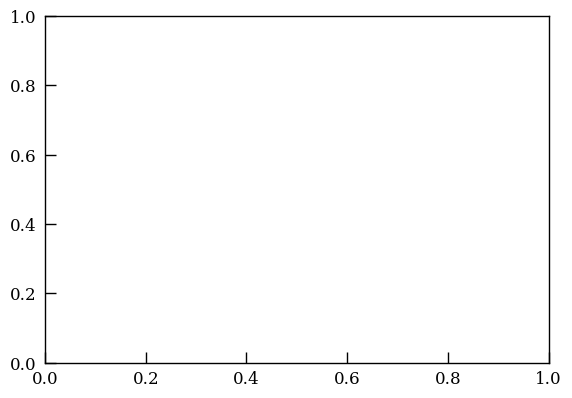

In [57]:
fig, axes = plt.subplots(1, 1)

data_corr, data_corr_err = apply_calibration(data=data, data_err=data_err)
# print(data_corr)


axes.plot(data.index.to_numpy(), (data_corr["TE0025"]).to_numpy(), label="TE0025")
axes.plot(data.index.to_numpy(), (data_corr["TE0024"]).to_numpy(), label="TE0024")
#axes.axvline(datetime.datetime(2024, 5, 3, 13, 30, 0), label="Recirculation ON", color="red")
#axes.axvline(datetime.datetime(2024, 12, 3, 14, 30, 0), label="Recirculation ON", color="orange")
axes.set_xlim(datetime.datetime(2024, 12, 2, 0, 0, 0), datetime.datetime(2024, 12, 4, 0, 0, 0))
axes2 = axes.twinx()
axes2.plot(data.index.to_numpy(), 1e6*data["IE_Card02"].to_numpy(), color="blue", label="IE_Card02")
axes2.plot(data.index.to_numpy(), 1e6*data["IE_Card01"].to_numpy(), color="orange", label="IE_Card01")
axes.legend()
axes2.legend(loc="lower right")
# axes.set_xlabel("Datetime")
axes.set_ylabel("Temperature [K]")
axes2.set_ylabel("Current [nA]")
# axes.set_title("NP04 Temperature Evolution")
fig.tight_layout()
#fig.savefig(f"{path_to_save_plots}/np04_temp_evolution_TE0048.png", format="png")

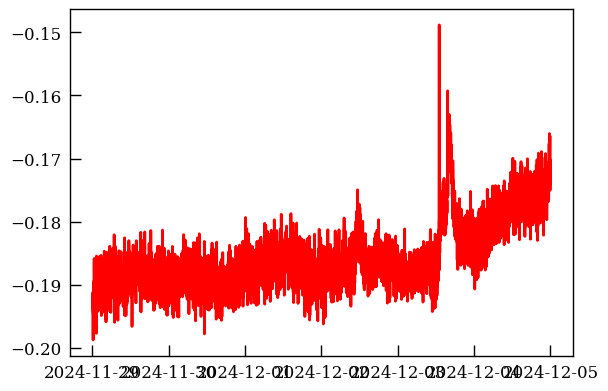

In [26]:
fig, axes = plt.subplots(1,1)
# axes.plot(
#     data.index.to_numpy(),
#     (data["IE_Card01"]/data["IE_Card02"]).to_numpy(),
#     color="blue"
# )
axes.plot(
    data.index.to_numpy(),
    (data["TE0024"]/data["IE_Card01"]).to_numpy()-(data["TE0025"]*data["IE_Card02"]).to_numpy(),
    color="red"
)
#axes.set_xlim(datetime.datetime(2024, 12, 3, 12, 0 , 1), datetime.datetime(2024, 12, 3, 14, 30, 0))